# <font color=green>deepBreaks Applications</font>
## Modeling spectral tuning sites of opsin proteins based on amino-acid sequence...  

# <font color=red>Step 0: mySQL DB Setup -</font> Script 0
## *The following text is a script written in mySQL format. You can copy and paste this directly into a mySQL text file or query window within mySQL workbench.*
```
DROP DATABASE vizphiz;
CREATE DATABASE vizphiz;
USE vizphiz;

CREATE TABLE lamdamax
(
id int unsigned not null primary key,
genus varchar(50),
species varchar(50),
celltype varchar(50),
cellsubtype varchar(50),
lamdamax decimal(9,5),
error decimal(9,5),
chromophore varchar(50),
method varchar(50),
stage varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE heterologous
(
hetid int unsigned not null primary key,
genus  varchar(50),
species varchar(50),
accession varchar(500),
mutations varchar(500),
lamdamax decimal(9,5),
error decimal(9,5),
cellculture varchar(50),
purification varchar(50),
spectrum varchar(50),
sourcetype varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE links
(
linkid int unsigned not null primary key,
accession varchar(500),
maxid int,
refid int,
evidence varchar(1000)
);

CREATE TABLE search
(
searchid int unsigned not null primary key,
researcher varchar(50),
month int,
year int,
engine varchar(500),
keywords varchar(500)
);

CREATE TABLE opsins
(
opsinid int unsigned not null primary key,
genefamily varchar(50),
genenames varchar(50),
genus varchar(50),
species varchar(50),
db varchar(50),
accession varchar(500),
dna varchar(10000),
aa varchar(3333),
refid int
);

CREATE TABLE refs
(
refid int,
doilink varchar(100),
searchid int
);
``` 

In [2]:
#All neccessary packages to import for data process steps.
import mysql
import mysql.connector
#install mysql-connector-python // NOT mysql-connector
import argparse
import re
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

# <font color=red>STEP 0: Data Base Setup -</font> Script 1 - Import heterologous.tsv into mySQL


In [ ]:

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[11])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

# <font color=red>STEP 0: Data Base Setup -</font> Script 2 - Import opsindb.tsv into mySQL

In [ ]:

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[11])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

# <font color=red>STEP 1: Extract Data From Vizphiz</font>
### Output = 5 different 'versions' // 'splits' of the data. 
### !Take outputs and run through MAFFT before moving on to STEP2!
### Suggested parameters for 'mafft' alignment are...
1. Fasta Format (Sorted)

2. Strategy = FFT-NS-2 // G-INS-1

In [3]:
wd_output = 'wds.txt'
sws_output = 'swd.txt'
mws_output = 'mwd.txt'
rod_output = 'rod.txt'
wd_ni_output = 'wds_ni.txt'
wh_metadata = 'wds_meta.tsv'
sw_metadata = 'sws_meta.tsv'
mw_metadata = 'mws_meta.tsv'
rh_metadata = 'rod_meta.tsv'
wd_ni_metadata = 'wds_ni_meta.tsv'
m = 0
s = 0
l = 0
r = 0
c = 0
acc_list = []
duped = 0

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()


for x in myresult:       
  #Keep all accessions in a list -- don't print 
  if (x[3] in acc_list):
    #print ("\n\n\n****Accession Exists" + x[2] + "\n\n" )
    duped=1
  #First 2 of if statements ignore ancestral (pigment named) or mutated genes
  if (duped==1) :
    duped=0
  #do not print if contains the word "pigment" which is an ancestral sequence

  else :
#REG-DATA SECTION    
       with open(wd_output, 'a') as f:
          if m == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if(x[3]) == "NM_001014890.2":
            pass
          else:
            m += 1 
            #This makes the fasta format file
            seq = ">S" + str(m)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

       with open(wd_ni_output, 'a') as f:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
        if (p.match(x[2])):
          pass
        else:
          if c == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if(x[3]) == "NM_001014890.2":
            pass
          else:
            c += 1 
            #This makes the fasta format file
            seq = ">S" + str(c)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

       with open(sws_output, 'a') as f:
        p = re.compile('^SWS|^UVS')
        if p.match(x[2]):
          s+=1
          if s == 1:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")  
        #This makes the fasta format file
          seq = ">S" + str(s)
          f.write(seq)
          seq2 = str('\n' + x[5] + '\n')
          f.write(seq2)

       with open(mws_output, 'a') as f:
        p = re.compile('^MWS|^LWS')
        if p.match(x[2]):
          l+=1
          if l == 1:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          #This makes the fasta format file
          seq = ">S" + str(l)
          f.write(seq)
          seq2 = str('\n' + x[5] + '\n')
          f.write(seq2)

       with open(rod_output, 'a') as f:
        p = re.compile('Rh[0-2]|exoRh')
        if p.match(x[2]):
          if r == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if(x[3]) == "NM_001014890.2":
            pass
          else:
            r+=1
            #This makes the fasta format file
            seq = ">S" + str(r)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

#METADATA SECTION
       with open(wh_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        if m == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
          g.write("Bovine\t500\tBos_tarus.0000\tRh1\tNM_001014890\n")
        if(x[3]) == "NM_001014890.2":
          pass
        else:        
          md =  str("S" + str(m) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(wd_ni_metadata, 'a') as g:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
        if p.match(x[2]):
          pass
        #This makes the metadata formatted for a linear regression model.
        else:
          if c == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")
          if(x[3]) == "NM_001014890.2":
            pass
          else:  
            md =  str("S" + str(c) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            g.write(md)

       with open(sw_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        p = re.compile('^SWS|^UVS')
        if p.match(x[2]):
          if s == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")  
          md =  str("S" + str(s) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(mw_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        p = re.compile('^MWS|^LWS')
        if p.match(x[2]):
          if l == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
            g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")  
          md =  str("S" + str(l) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(rh_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        p = re.compile('Rh[0-3]|exoRh')
        if p.match(x[2]):
          if r == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")
          if(x[3]) == "NM_001014890.2":
            pass
          else:  
            md =  str("S" + str(r) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            g.write(md)

# <font color=red>STEP 2: Format Alignments for 'deepBreaks'</font>
## REMINDER - Take outputs from STEP 1 and run through MAFFT before moving on to STEP2


In [115]:
#enter list of aligned text files here.
inputs = ['wds_ni_aligned.txt','wds_aligned.txt','rod_aligned.txt','sws_aligned.txt','mws_aligned.txt']
##enter list of names for desired formatted fasta files here.
output = ['wds_ni_fmt.fasta','wds_fmt.fasta','rod_fmt.fasta','sws_fmt.fasta','mws_fmt.fasta']
i=0
k = 0
for files in inputs:
    lines = open(inputs[i]).readlines()
    file = open(output[i], 'a+')
    #line_count = len(lines)
    #tab_entry = ""
    #call = input("How Many Lines Per Alignment?: ")
    #count = int(call)
    #loop = range(int(count))
    m=0
    for line in lines:
        snip = str(lines[k])
        if '>' in snip:
            if m == 0:
                m+=1
            else:
                file.write("\n")
            file.write(snip)
        else:
            entry = ""
            entry = str(snip.replace("\n",""))
            file.write(entry)
        k+=1
    k = 0
    i+=1
    file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'wds_aligned.txt'

# <font color=red>STEP 3: deepBreaks</font>
## THIS IS A LONG SECTION! 
### STEP 4 doesn't start until Cell 34

In [116]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [117]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = 'wds_ni_fmt.fasta' 

# path to metadata
metaDataFileName = 'wds_ni_meta.tsv' 

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'amino-acid'

# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'reg' 
sampleFrac=1

In [118]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [119]:
%%time
print('reading meta-data')
# importing metadata
metaData = prp.read_data(metaDataFileName, seq_type = None, is_main=False)
print('metaData:', metaData.shape)

# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)

positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading meta-data
metaData: (690, 4)
reading fasta file
Done
Shape of data is:  (690, 497)
CPU times: total: 297 ms
Wall time: 295 ms


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [120]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


,Lambda_Max,Species,Opsin_Family,Accession
Bovine,500.0,Bos_tarus,Rh1,NM_001014890
S1,502.0,Neoniphon_sammara,Rh1,U57536.1
S2,502.0,Neoniphon_argenteus,Rh1,U57540.1
S3,481.0,Neoniphon_aurolineatus,Rh1,U57541.1
S4,494.0,Sargocentron_punctatissimum,Rh1,U57543.1


In [121]:
print('sequence data looks like this:')
df.head()

sequence data looks like this:


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p488,p489,p490,p491,p492,p493,p494,p495,p496,p497
Bovine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [122]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (690, 497)
Shape of data after missing/constant care:  (690, 289)
CPU times: total: 203 ms
Wall time: 182 ms


In [123]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df, imbalance_threshold=0.025)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (690, 289)
Shape of data after imbalanced care:  (690, 278)
CPU times: total: 1 s
Wall time: 1 s


In [124]:
%%time
# you may want to perform your analysis only on a random sample of the positions.
# Here you can have a random sample of your main data set.
print('number of columns of main data befor: ', df.shape[1])
df = prp.col_sampler(dat=df, sample_frac=sampleFrac)
print('number of columns of main data after: ', df.shape[1])

number of columns of main data befor:  278
number of columns of main data after:  278
CPU times: total: 0 ns
Wall time: 0 ns


In [125]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  278
number of columns of main data after:  277
CPU times: total: 1.22 s
Wall time: 1.21 s


In [126]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)

one-hot encoding the dataset
CPU times: total: 281 ms
Wall time: 257 ms


In [127]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(906, 906)
CPU times: total: 1.84 s
Wall time: 1.84 s


In [128]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


,p59_G,p59_S,p60_P,p61_I,p61_W,p61_Y,p62_E,p62_L,p62_NGAFS,p63_G,...,p432_I,p432_S,p432_T,p434_E,p434_G,p434_S,p434_V,p435_E,p435_N,p435_S
p59_G,0.000000,0.107077,0.710099,0.787153,0.206606,0.620700,0.458450,0.811654,0.820974,0.278483,...,0.859621,0.722719,0.504067,0.900163,0.884025,0.993616,0.797469,0.519494,0.704744,0.325397
p59_S,0.107077,0.000000,0.741140,0.700388,0.291560,0.609520,0.495681,0.785672,0.727197,0.273501,...,0.842787,0.764094,0.557170,0.888751,0.771578,0.924007,0.773182,0.513142,0.736359,0.265580
p60_P,0.710099,0.741140,0.000000,0.136016,0.884245,0.887921,0.822269,0.938878,0.953179,0.857413,...,0.959304,0.937113,0.927644,0.842048,0.962677,0.962677,0.941286,0.860701,0.018135,0.829533
p61_I,0.787153,0.700388,0.136016,0.000000,0.866022,0.870277,0.911327,0.929255,0.786680,0.834965,...,0.952897,0.927213,0.916253,0.937040,0.956802,0.956802,0.932043,0.838771,0.152120,0.920543
p61_W,0.206606,0.291560,0.884245,0.866022,0.000000,0.693267,0.348708,0.832722,0.997185,0.188184,...,0.888624,0.638599,0.374922,0.969036,0.897856,0.897856,0.839313,0.618769,0.882107,0.320958


In [129]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat=cr,
                       report_dir=report_dir,
                       threshold=.25, needs_pivot=False)

finding colinear groups
CPU times: total: 109 ms
Wall time: 119 ms


In [130]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


,feature,group
0,p59_G,g0
1,p59_S,g0
2,p60_P,g1
3,p61_I,g1
4,p61_W,g0


Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [131]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)

grouping features
CPU times: total: 156 ms
Wall time: 163 ms


In [132]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before collinearity care:  (690, 906)
Shape of data after collinearity care:  (690, 336)


In [133]:
# merge with metadata
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [134]:
%%time
models_to_select = 3 # number of top models to select
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned,
                                                    meta_var=mt,
                                                    model_type=anaType, 
                                                    models_to_select=models_to_select,
                                                    report_dir=report_dir)

,Description,Value
0,session_id,123
1,Target,Lambda_Max
2,Original Data,"(690, 337)"
3,Missing Values,False
4,Numeric Features,336
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(482, 233)"


CPU times: total: 43.1 s
Wall time: 1min 2s


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

Light Gradient Boosting MachineDone
Light Gradient Boosting Machine  Done
Random Forest RegressorDone
Random Forest Regressor  Done
Bayesian RidgeDone
Bayesian Ridge  Done


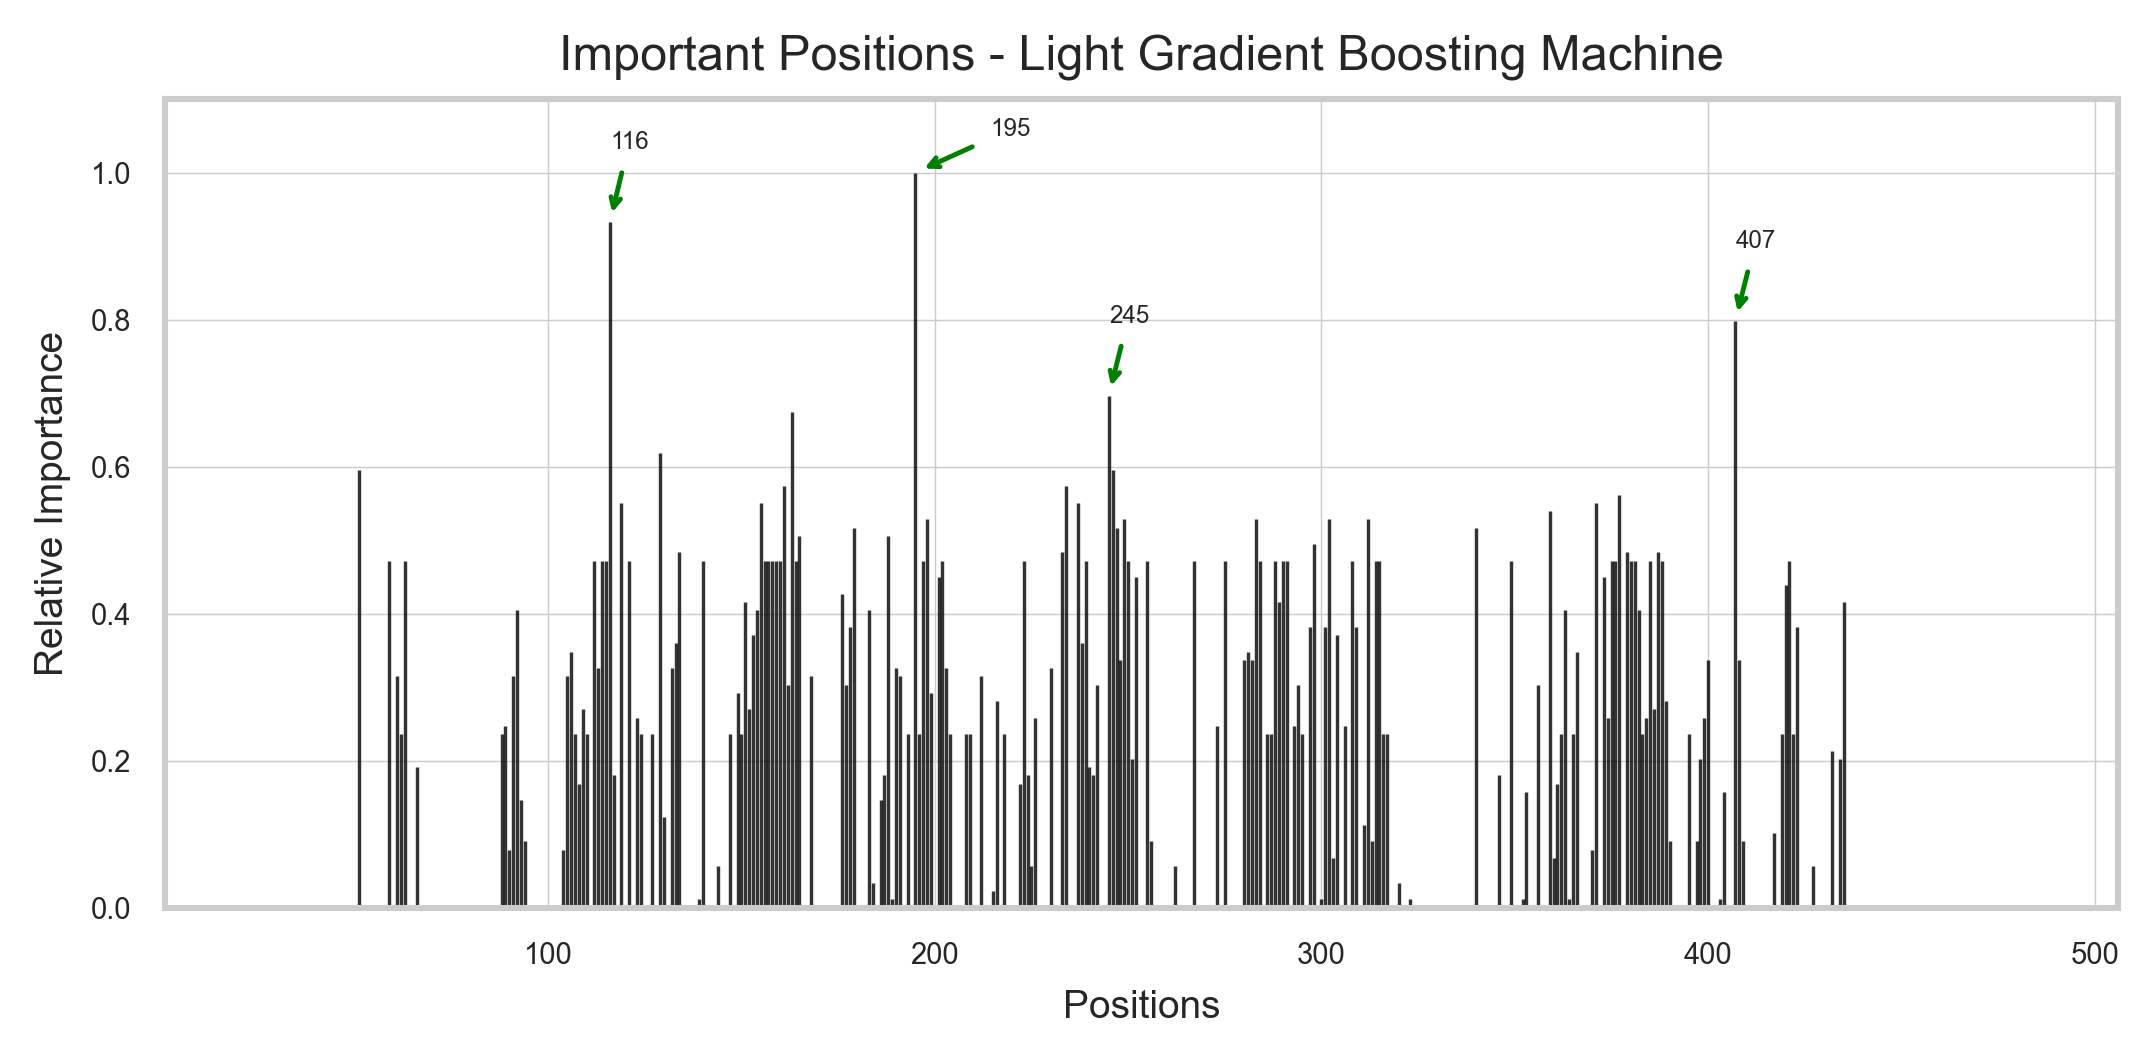

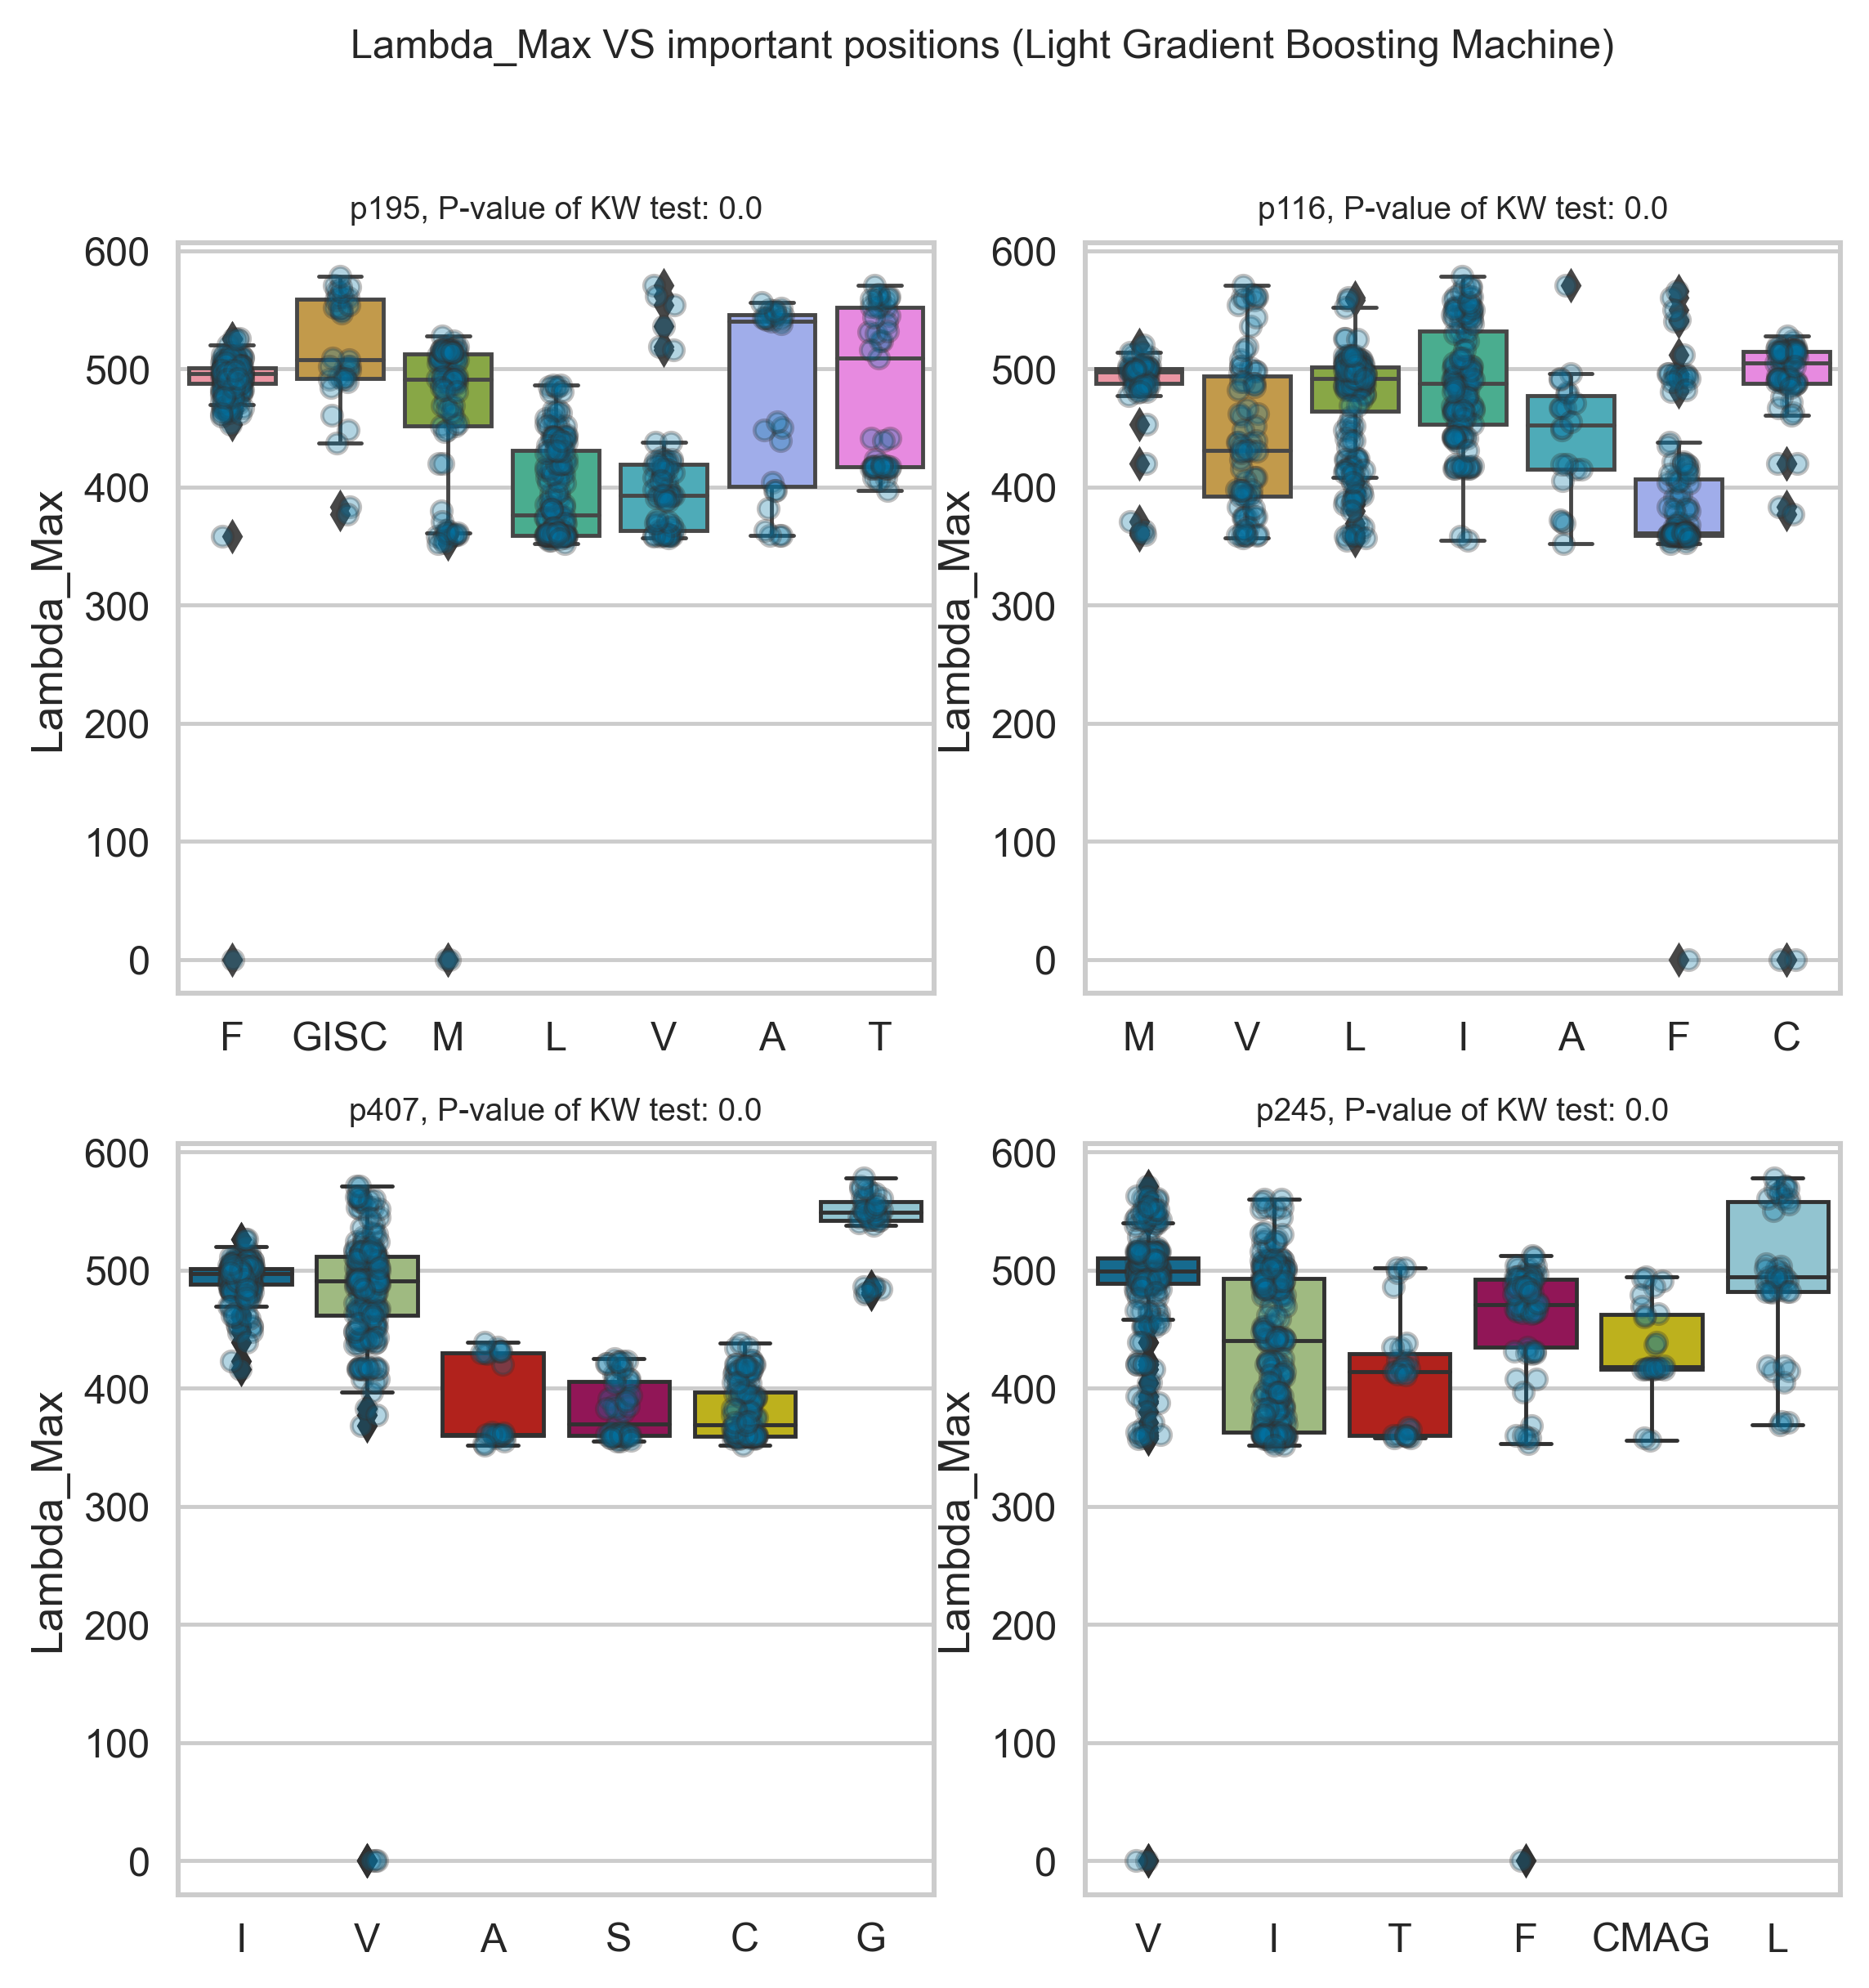

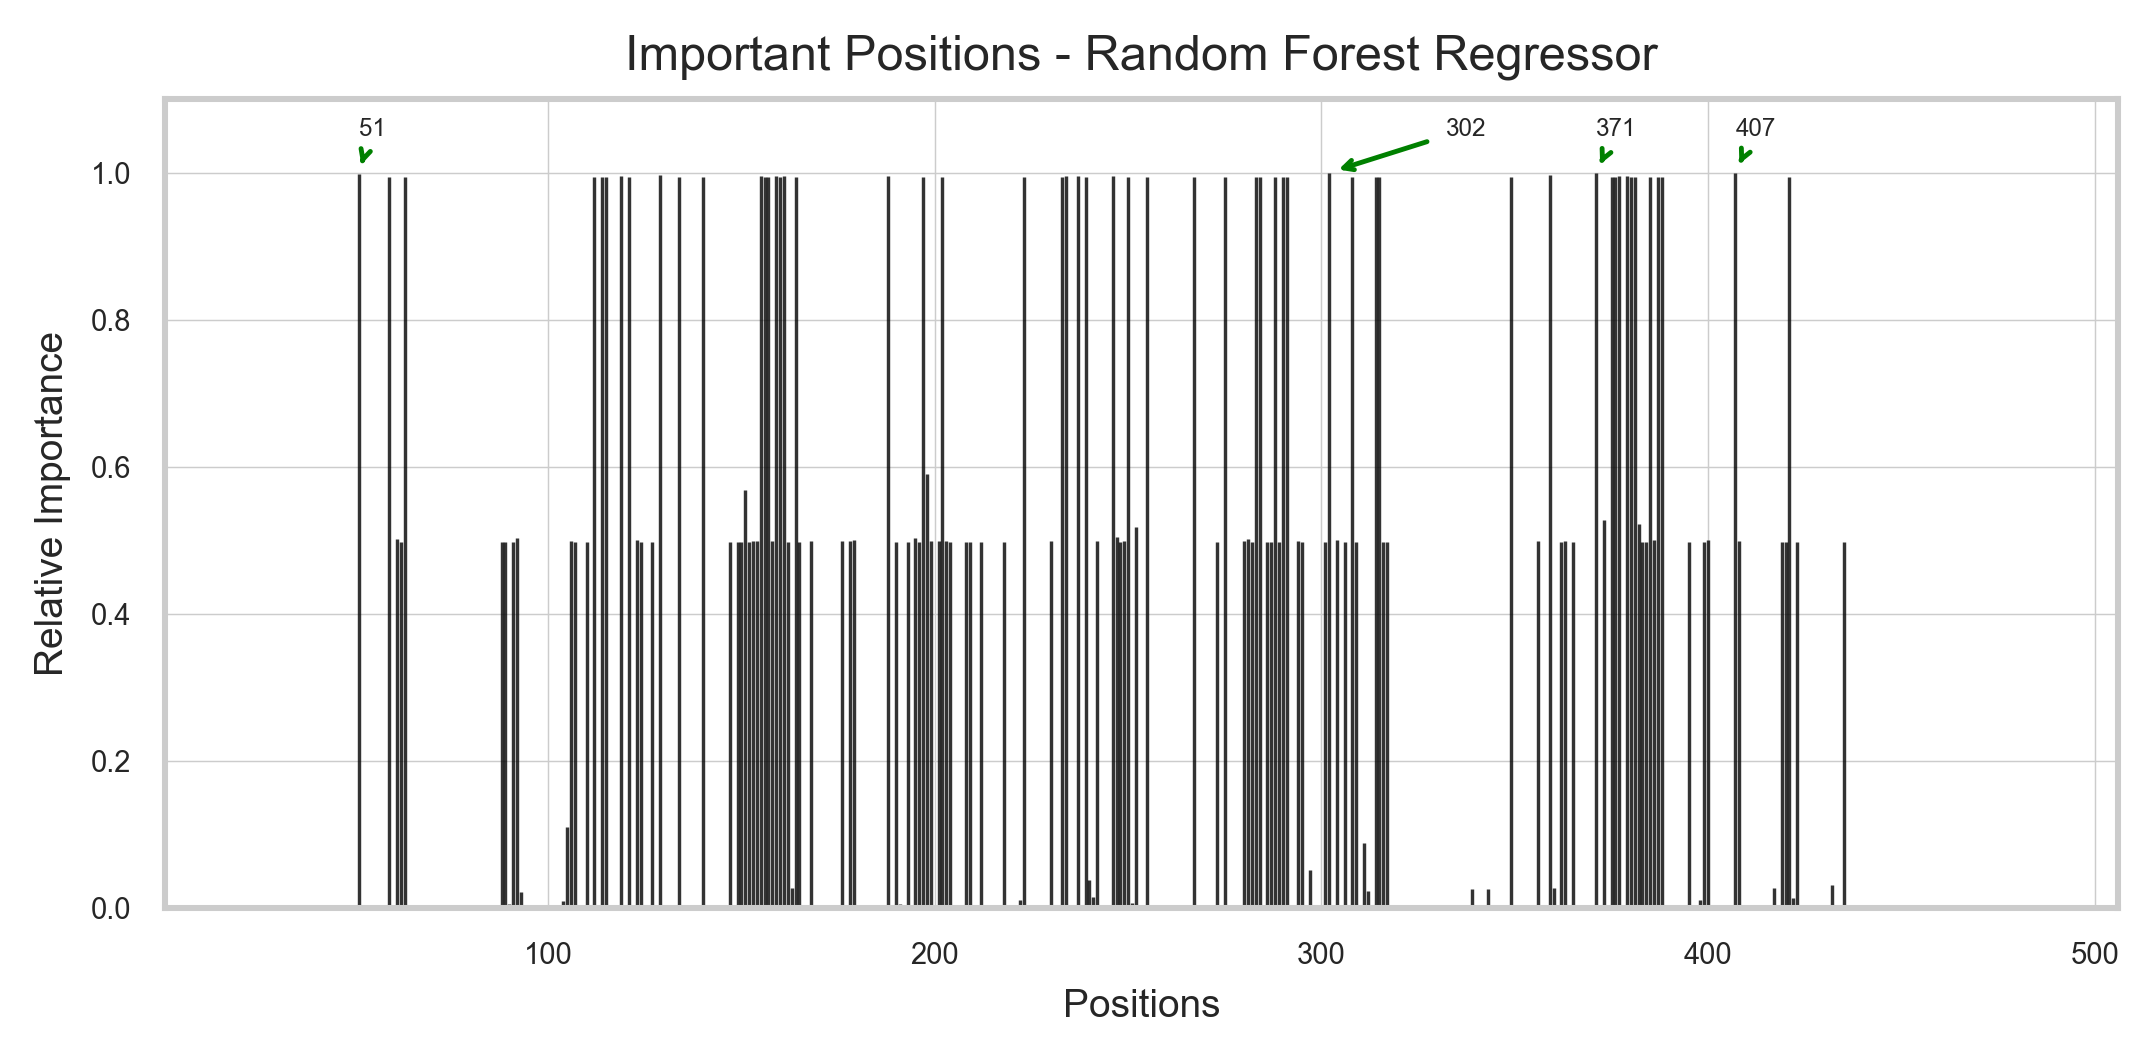

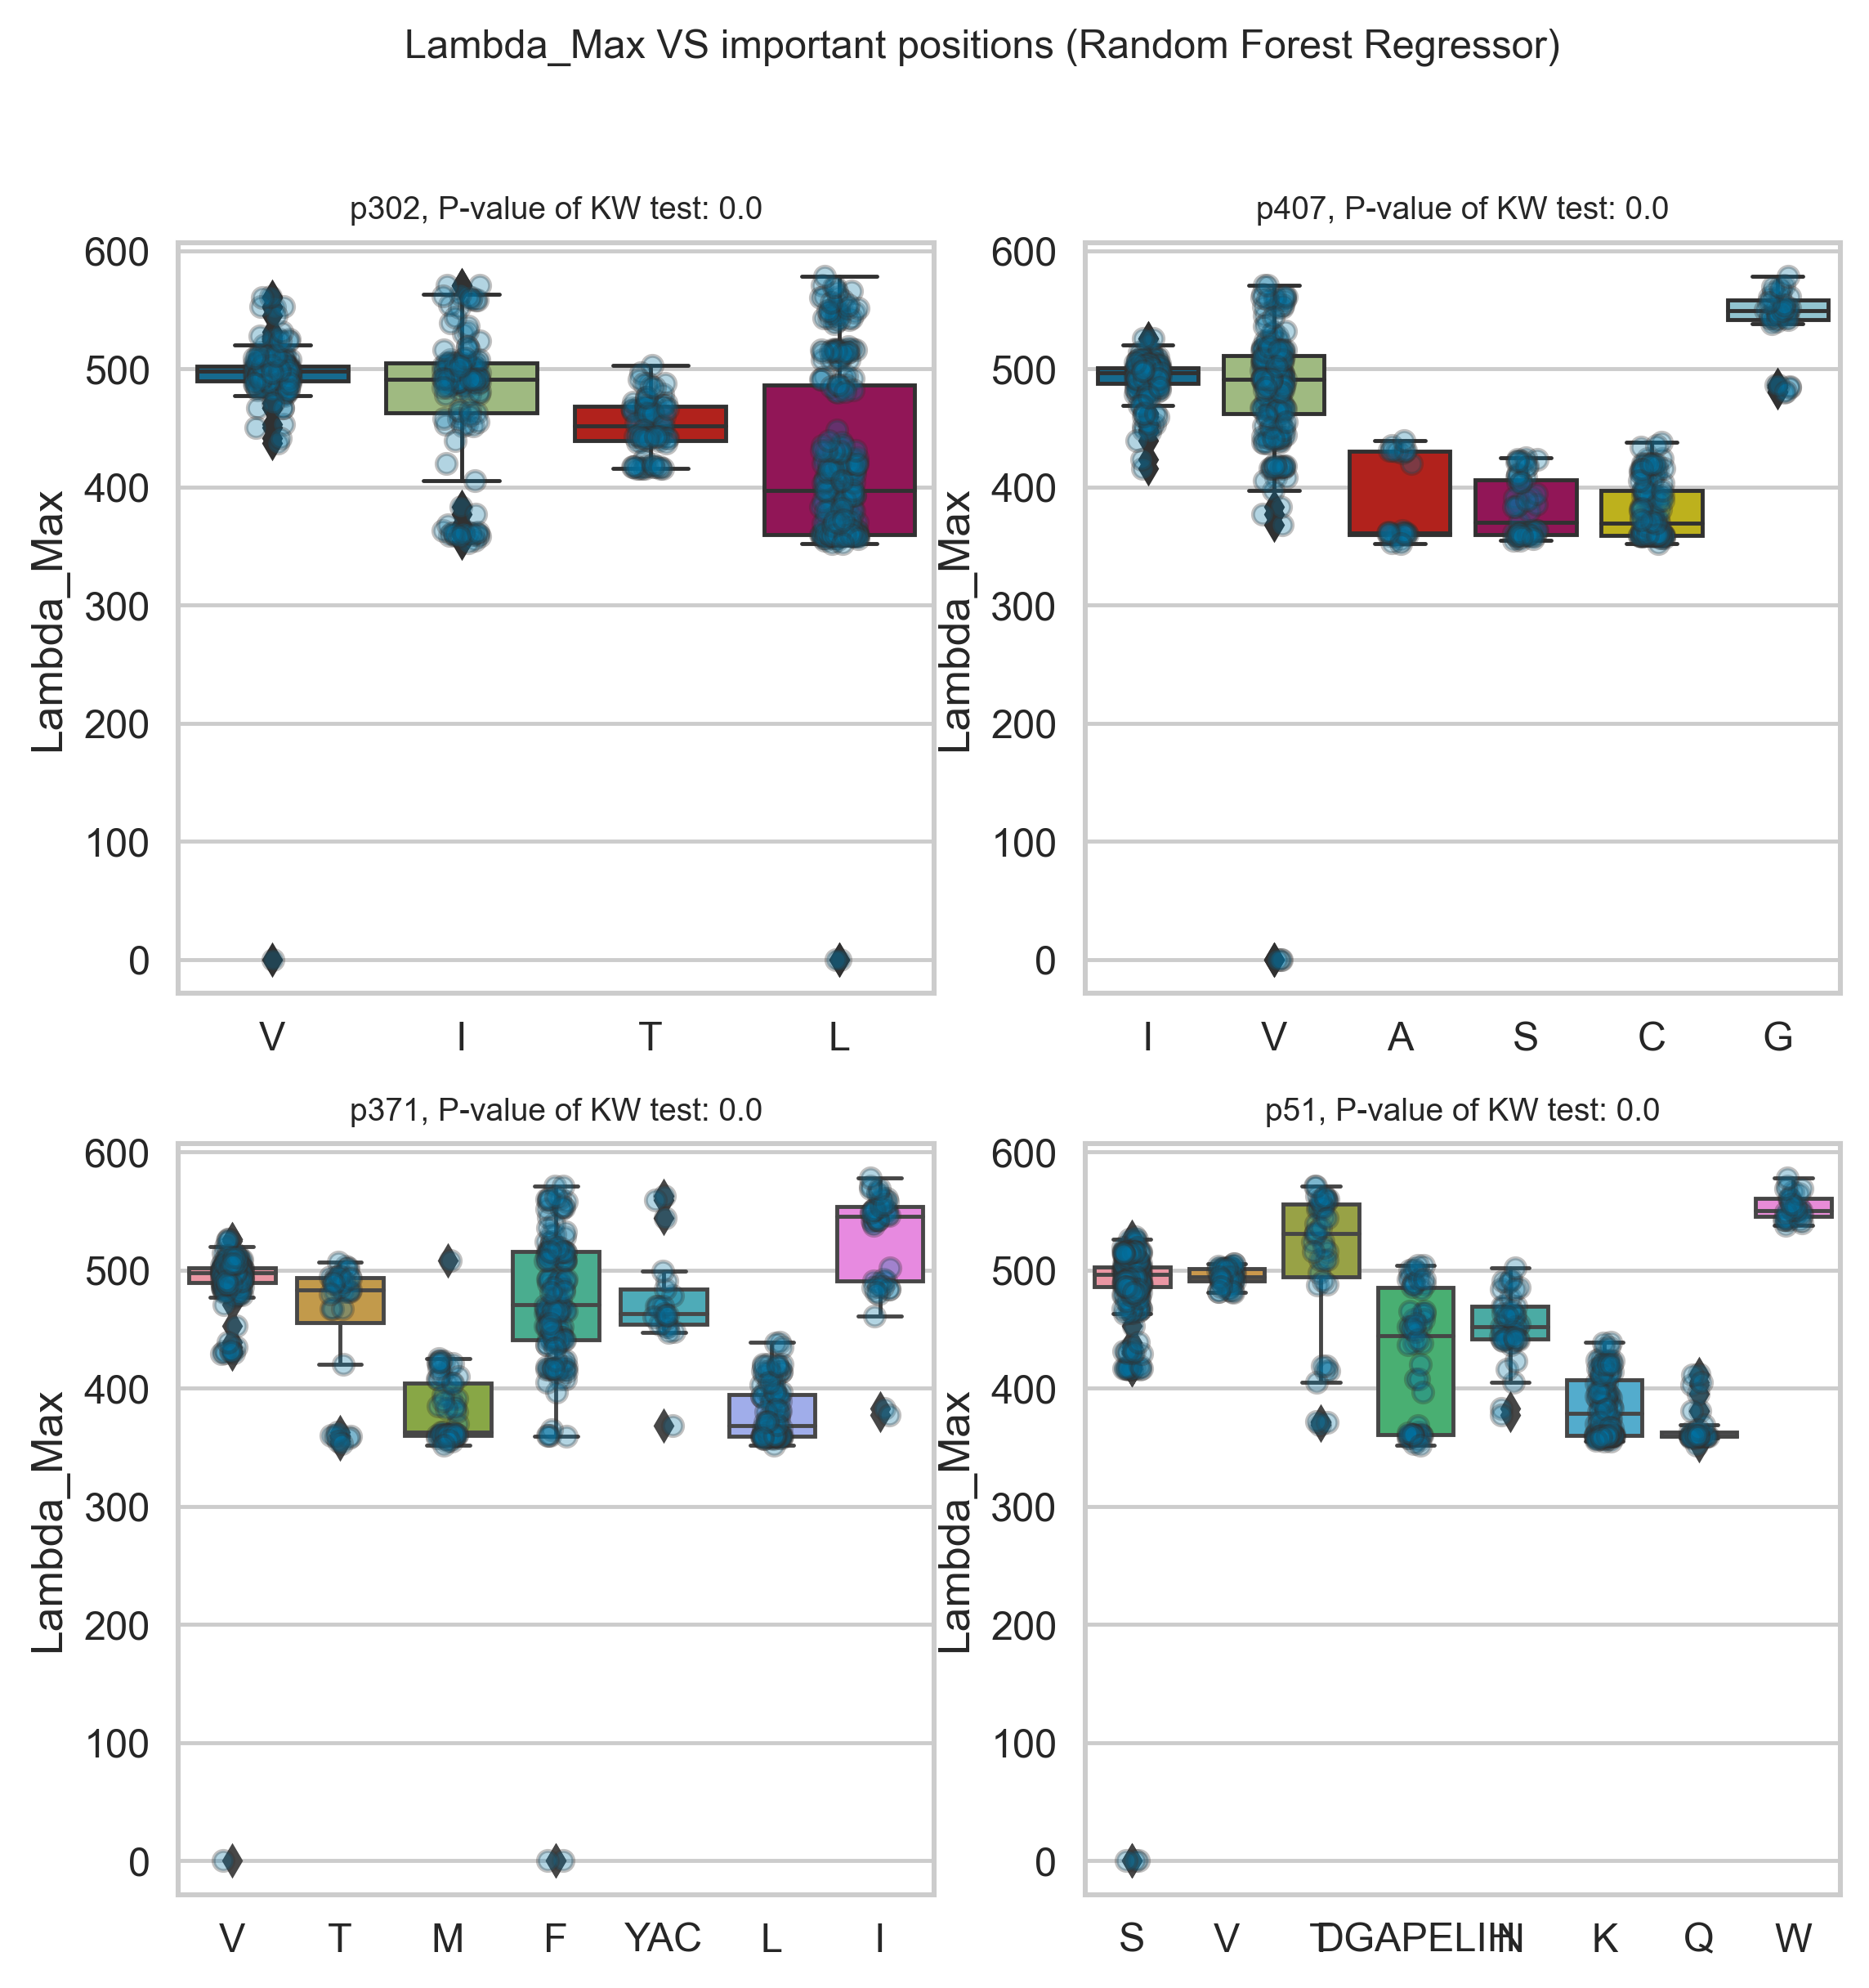

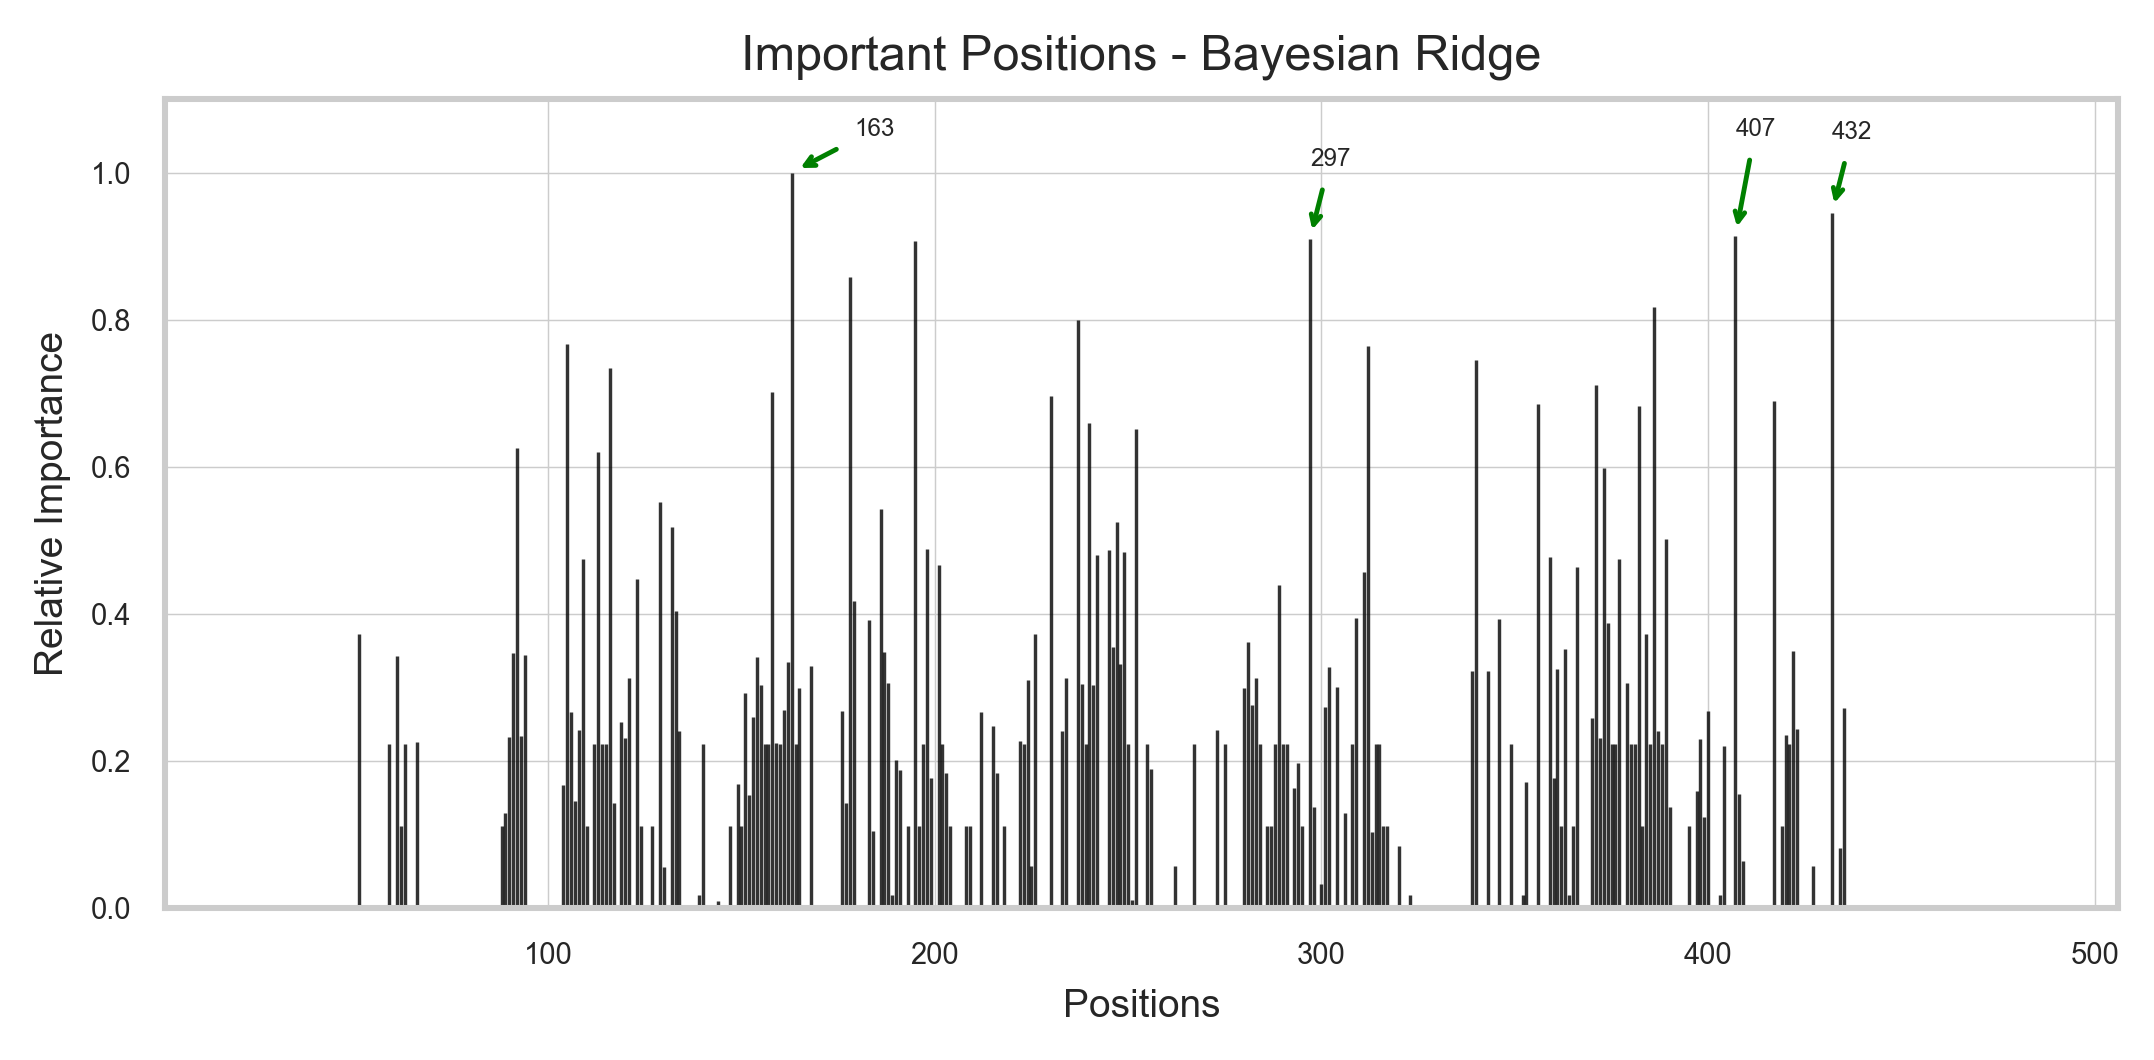

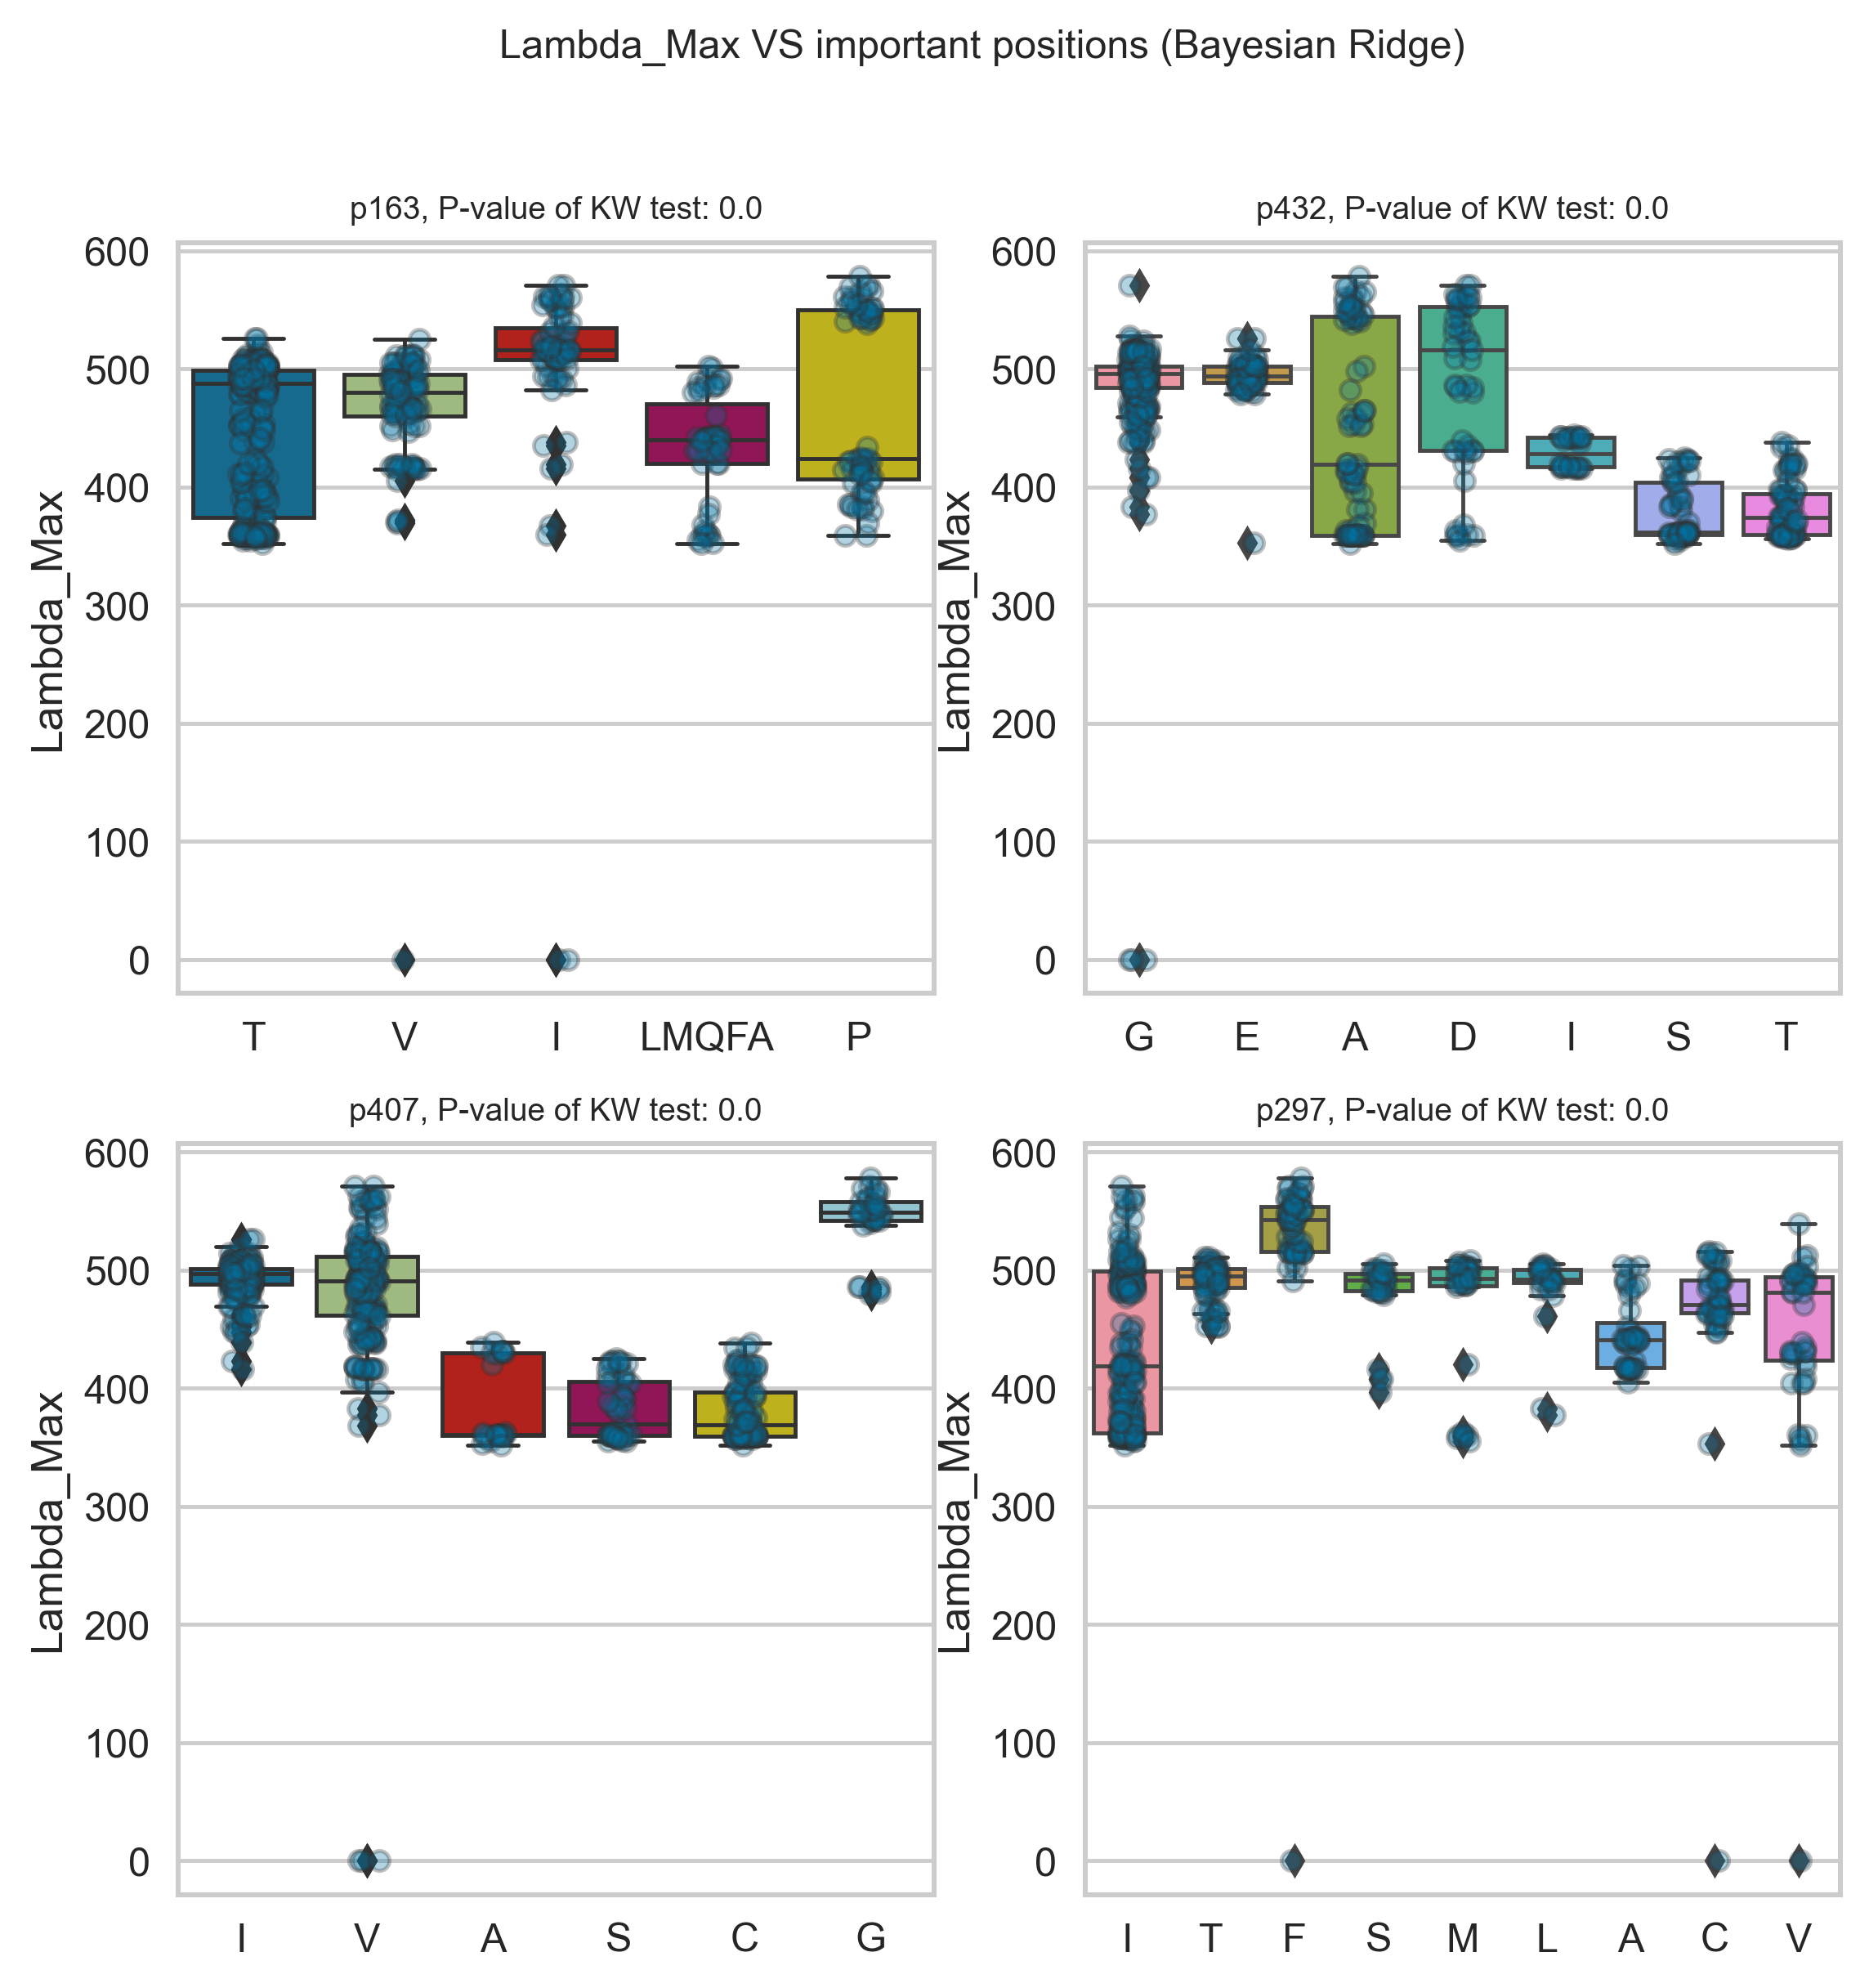

In [135]:
for i in range(models_to_select):
    # calculate the featre importances
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i],
                         train_cols=train_cols, grouped_features=dc,
                         n_positions=positions, report_dir=report_dir)
    # visualize the lollipop plot for features based on each model
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    # visualize the boxplots for features based on each model
    viz.plot_imp_model(dat=df, trained_model=top_models[i],
                       model_name=model_names[i],
                       train_cols=train_cols, grouped_features=dc,
                       meta_var=mt, n_positions=positions,
                       model_type=anaType, report_dir=report_dir)

meanDone


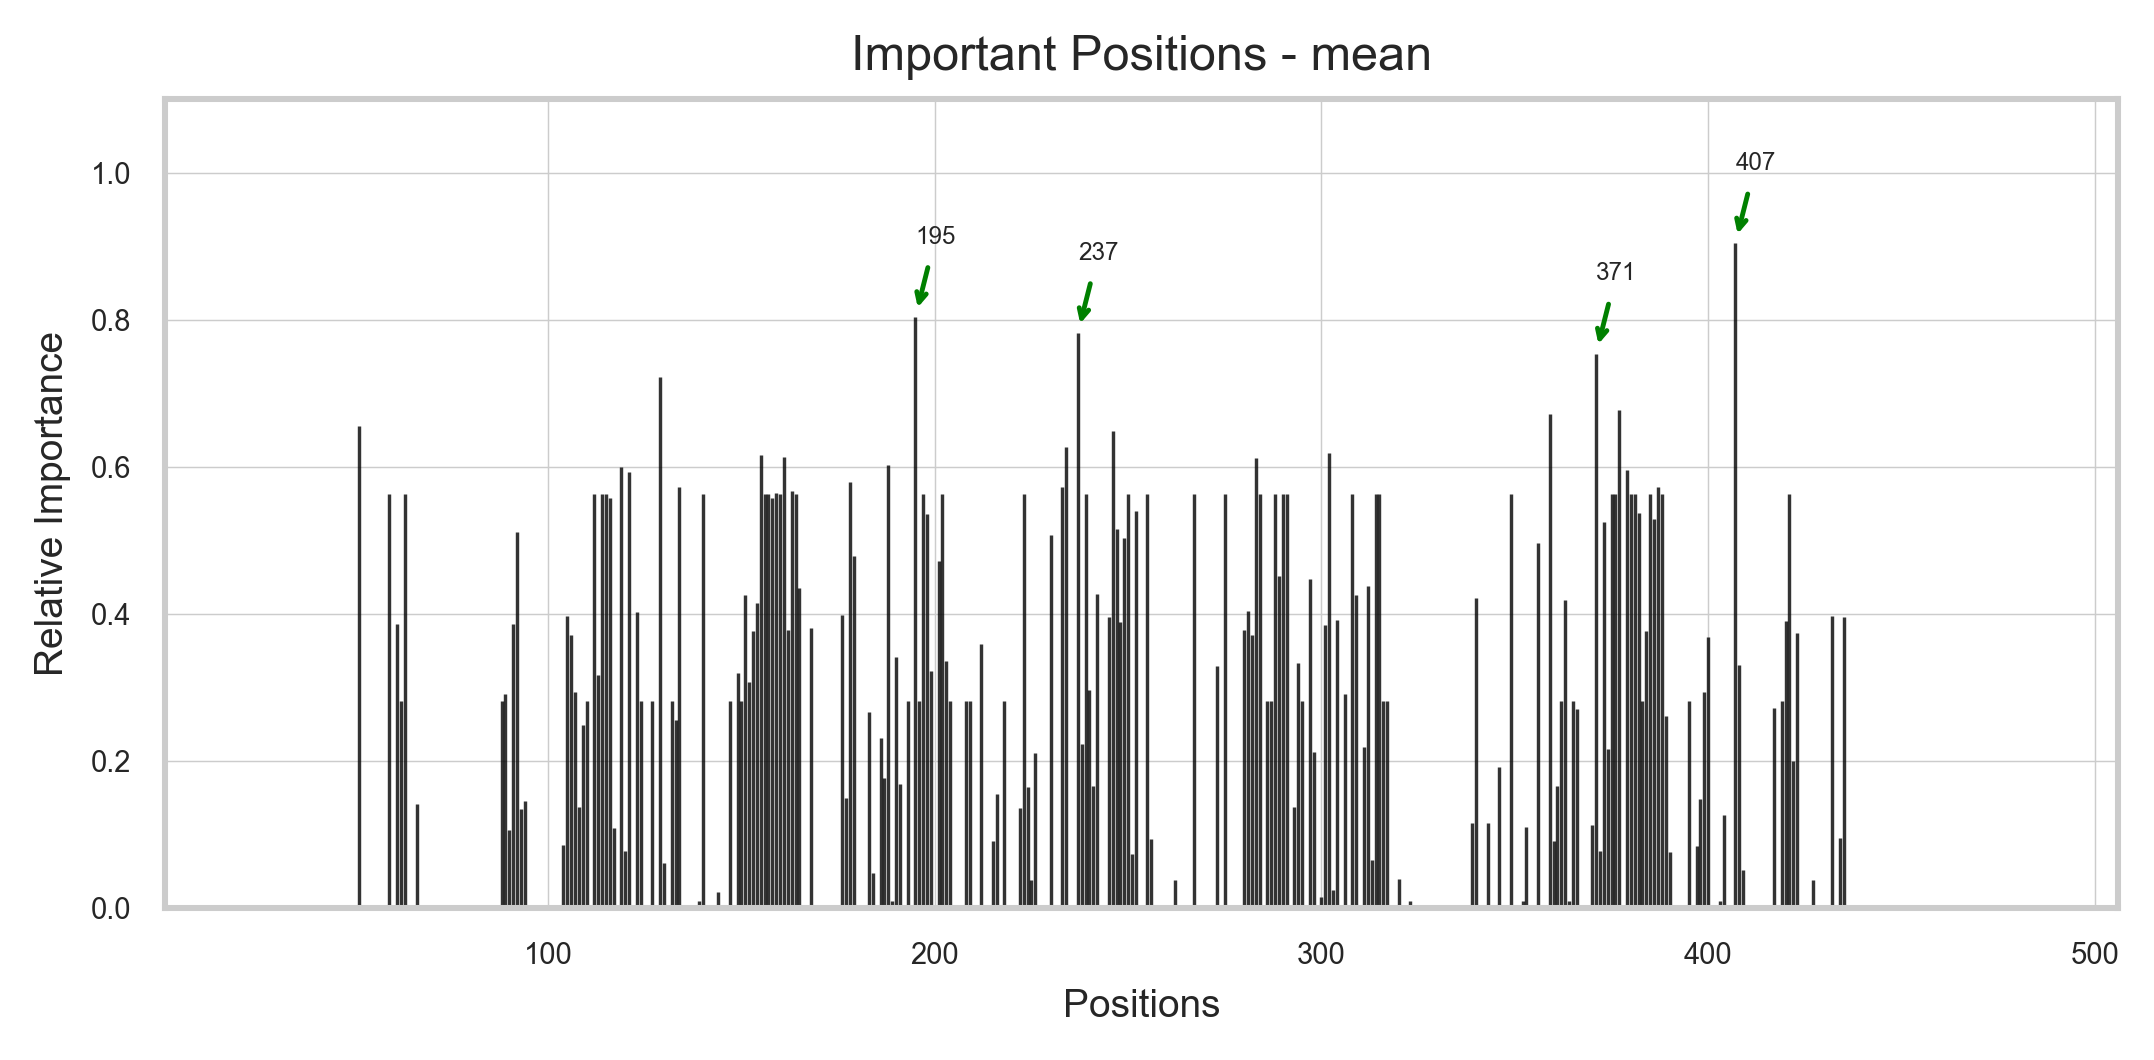

In [136]:
# merging the results for all the top models
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, 
                              train_cols=train_cols,grouped_features=dc,
                              n_positions=positions,report_dir=report_dir)

# lollipop plot for the merged results
viz.dp_plot(dat=mean_imp,figsize=(7.2, 3),
            model_name='mean',
            imp_col='mean_imp', 
            report_dir=report_dir)

In [ ]:
# visualizing top positions  
viz.plot_imp_all(trained_models=top_models, dat=df, train_cols=train_cols,
                 grouped_features=dc, meta_var=mt, model_type=anaType,
                 n_positions=positions, report_dir=report_dir)

# <font color=red>STEP 4: Translate Candidate STSs</font> 
## Optional step IF running the classifier model, but could still be useful.
### To find CSTSs, got to the deepBreaks output folder and find the excel sheet 'avg_top_models_feature_importance'
### Sort the top model's feature importance column by 'largest-to-smallest' and take x# of those positions.

In [138]:
#STEP 4: Translate Candidate STSs 
#Optional step IF running the classifier model, but could still be useful.
#To find CSTSs, got to the deepBreaks output folder and find the excel sheet 'avg_top_models_feature_importance'
#Sort the top model's feature importance column by 'largest-to-smallest' and take x# of those positions.
#enter list of candidate STSs below
impsites = input("Enter list CSTSs: ")
#enter desired name of output text file.
#eg - If I'm translating sites from a LRM for the rods subset of my dataset I would have the output text file be named...
#output = rod_csts.txt
output = input("Enter Name of Output File: ")
seq = input("Enter Aligned Bovine Sequence: ")
site_list = impsites.split(',')
m = 0
tm = ''

#take the list of important sites and translate them to the bovine standard equivalent, we do this by taking the site number and subtracting the number of '-' between the start of the sequence and the desired site. 
for sites in site_list:

    k = int(sites)    
    gaps = seq[:k].count('-')
    #print("The number of gaps is " + str(gaps))
    trans_site = k - gaps

    if trans_site in range(39,65):
        tm = 'TM1'
    elif trans_site in range(72,99):
        tm = 'TM2'
    elif trans_site in range(110,140):
        tm = 'TM3'
    elif trans_site in range(151,173):
        tm = 'TM4'
    elif trans_site in range(200,230):
        tm = 'TM5'
    elif trans_site in range(245,275):
        tm = 'TM6'
    elif trans_site in range(285,310):
        tm = 'TM7'
    else:
        tm = 'Not in TM Region'
    

    #print(f"For site {k} the bovine equivalent is {trans_site}") 

    with open(output, 'a') as f:
        if m == 0:
                f.write("The following sites have been translated to the standard Bovine equivalent...\nFormat is before translation --> post translation to bovine equivalent.")   
                m+=1 
        f.write(f"Site {k} == {trans_site} // In {tm}\n")      